# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as ss

import random

pd.set_option('display.max_columns', 250)

In [56]:
data = pd.read_csv('orange_small_churn_data.txt')
labels = pd.read_csv('orange_small_churn_labels.txt')

data['label'] = labels > 0 #convert (-1, 1) to (True, False)

2\. Рассчитайте доли классов `отток` и `не отток`.

In [57]:
labels.value_counts() / len(labels)

-1
-1    0.925598
 1    0.074402
dtype: float64

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, однако анализировать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles

Подход следующий (см. лекцию 3.2):

Для бинарных пар можно использовать корреляцию Мэьтьюса
Для категориальных пар - Коэффициент V Крамера
Для смешанных пар категориальных и непрерывных величин используем разность их математических ожиданий.

In [58]:
num_data = data.iloc[:, :190]
cat_data = data.iloc[:, 190:230]

In [59]:
null_filter = num_data.isnull().sum(axis = 0) < 35000

In [60]:
# Непрерывные величины
mean_target = labels.mean().values
num_corr = num_data.loc[:, null_filter].mean(axis=0, skipna=True).to_frame(name='mean delta') - mean_target
num_corr.sort_values(by = 'mean delta', inplace = True, ascending = False)
num_corr.dropna(inplace = True)

In [61]:
num_corr.head()

,mean delta
Var153,6.186850e+06
Var38,2.574738e+06
Var133,2.285475e+06
Var76,1.488973e+06
Var163,4.859452e+05


In [62]:
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [63]:
null_filter = cat_data.isnull().sum(axis=0) < 35000

In [64]:
cat_columns_names = cat_data.loc[:, null_filter].columns
cramers_stats = []

for name in cat_columns_names:
    if cat_data[name].isnull().sum() != len(cat_data): #drop columns full of nan`s
        cramers_stats.append(cramers_v(cat_data[name], data['label']))
    else:
        cramers_stats.append(np.nan)

cat_corr = pd.DataFrame(zip(cat_columns_names, cramers_stats), columns=['feature', 'cramer_V'])
cat_corr.set_index('feature', inplace=True)
cat_corr.sort_values(by='cramer_V', inplace=True, ascending=False)
cat_corr.dropna(inplace = True)
cat_corr.head()

,cramer_V
feature,
Var199,0.093777
Var216,0.033805
Var193,0.021310
Var203,0.019226
Var212,0.018909


4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

In [67]:
top_num_features = num_corr.index[:5]

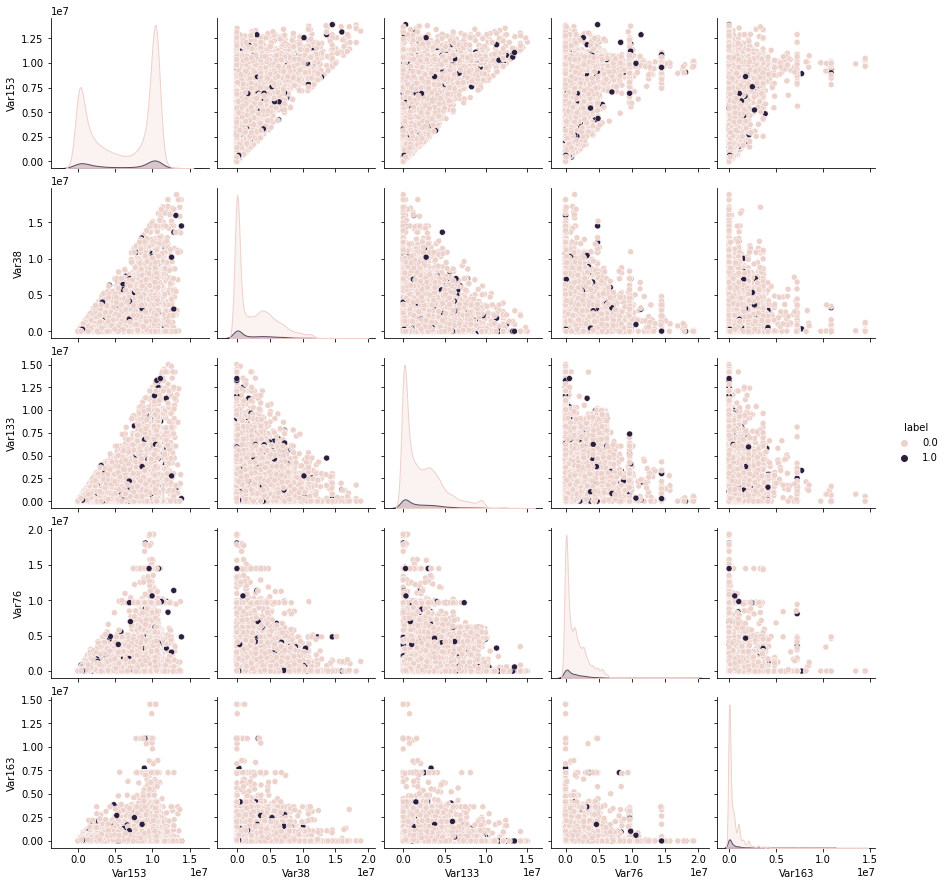

In [78]:
sns.pairplot(data=data[top_num_features.to_list() + ['label']], hue='label')
plt.show()

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [79]:
random_num_features = [random.choice(num_corr.index) for i in range(5)]
print(random_num_features)

['Var109', 'Var28', 'Var123', 'Var149', 'Var24']


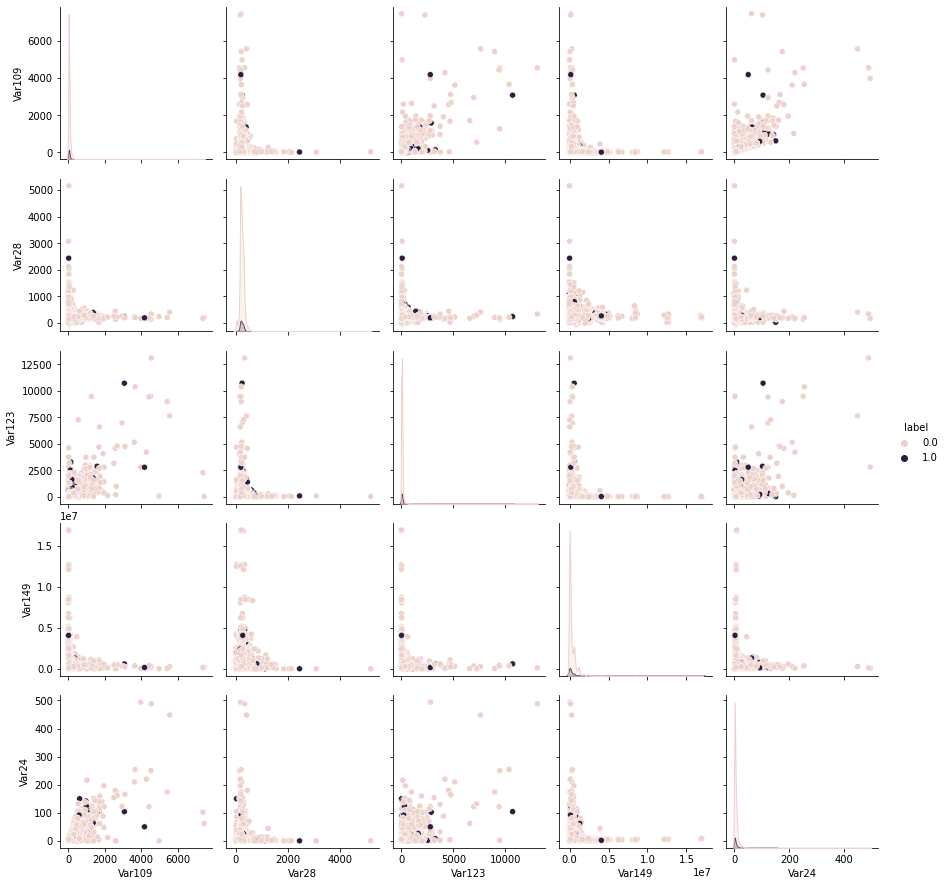

In [80]:
sns.pairplot(data=data[random_num_features + ['label']], hue='label')
plt.show()

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [84]:
bottom_num_features = num_corr.index[-5:]

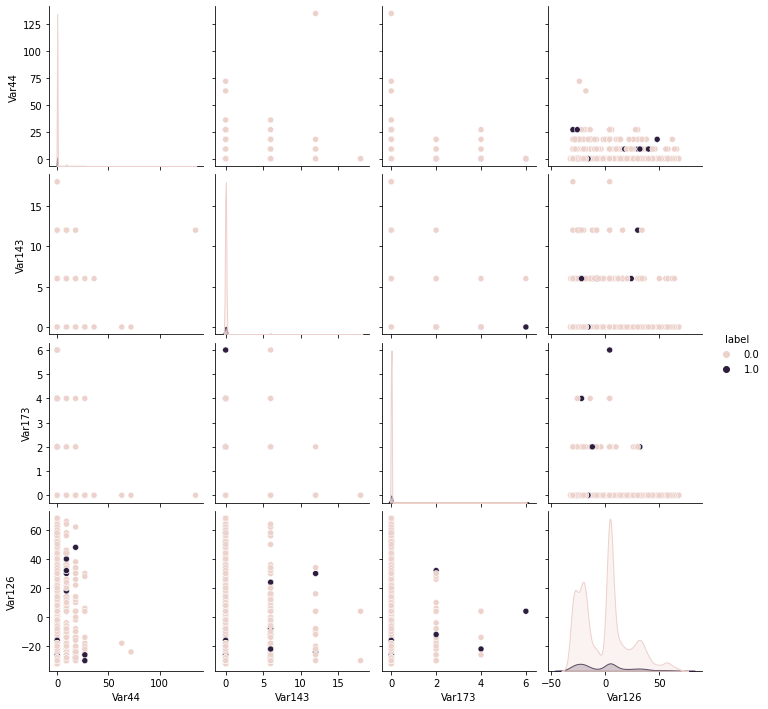

In [85]:
sns.pairplot(data=data[bottom_num_features.to_list() + ['label']], hue='label')
plt.show()

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

In [86]:
top_cat_features = cat_corr.index[:5]
plot_data = data[top_cat_features.to_list() + ['label']]

Wall time: 13.6 s


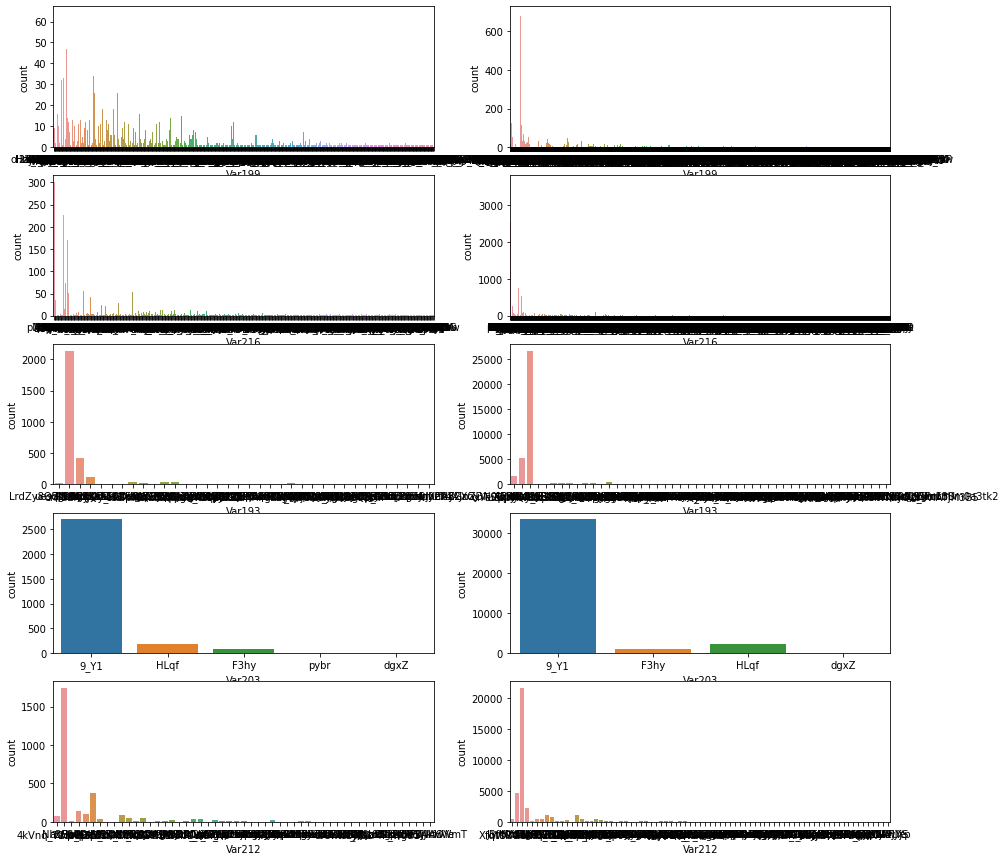

In [88]:
%%time
fig, axs = plt.subplots(5, 2, figsize = (15, 15))
for idx in range(5):
    sns.countplot(data=plot_data[plot_data['label'] == True], x=top_cat_features[idx], ax=axs[idx, 0])
    sns.countplot(data=plot_data[plot_data['label'] == False], x=top_cat_features[idx], ax=axs[idx, 1])

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?